# Generating Player-Based Tables from LiveSum Data

## Part 0: Importing all necessary libraries

In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import openai
from openai import OpenAI

## Part 1: Preprocessing the Data for use

### Part 1a. Loading Training and Test Data from the JSON Files

In [2]:
with open('train.json') as f:
    train_data = json.load(f)
train_df = pd.json_normalize(train_data)

#display the first few rows of the dataframes
display(train_df.head(20))

,text,table,id
0,And we're off for the start of the first half....,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513261
1,"And we're off, the First Half has kicked off. ...","Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513267
2,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513268
3,And we're underway in the first half. Player9(...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513270
4,The game is starting with the first half. Play...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513272
5,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513273
6,And we're off for the first half!. Player27(Aw...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513331
7,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513359
8,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25600388
9,The game is starting with the first half. The ...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25600393


### Part 1b. Use the first Training Row to see if we can generate some player-based stats tables

In [3]:
# Create a list to store the modified commentaries
modified_commentaries = []

# Iterate through the first 20 rows of train_df
for i in range(20):
    train_row = train_df.iloc[i]
    train_comm = train_row['text']
    
    # Make the commentary more readable
    commentary = train_comm.replace('. ', '.\n')
    modified_commentaries.append(commentary)



### Part 1c. Attempt to extract the Players involved into two separate DataFrames

In [4]:
# Adjust the regex pattern if necessary to match the actual format of the commentary
def extract_team_events(commentary, team_type):
    pattern = rf"Player\d+\s*\({team_type} Team\).*?"
    matches = re.findall(pattern, commentary)
    events = []
    for match in matches:
        player_match = re.search(r"Player\d+", match)
        if player_match:
            player = player_match.group()
            event = match.replace(player, "").strip()
            events.append({"Player": player, "Event": event})
    return pd.DataFrame(events)

# Create a list to store the results
results = []

# Iterate through the modified commentaries
for i in range(20):
    commentary = modified_commentaries[i]
    # Extract home and away team events
    home_team_df = extract_team_events(commentary, "Home")
    away_team_df = extract_team_events(commentary, "Away")
    
    # Store the commentary and extracted players in the results list
    results.append({
        "commentary": commentary,
        "home_players": home_team_df['Player'].unique().tolist(),
        "away_players": away_team_df['Player'].unique().tolist()
    })

# Convert the results into a DataFrame
commentary_df = pd.DataFrame(results)

# Display the resulting DataFrame
display(commentary_df)



,commentary,home_players,away_players
0,And we're off for the start of the first half....,"[Player10, Player8, Player2, Player6, Player5,...","[Player23, Player20, Player26, Player28, Playe..."
1,"And we're off, the First Half has kicked off.\...","[Player5, Player2, Player7, Player11, Player6,...","[Player28, Player23, Player27, Player22, Playe..."
2,The game is underway with the start of the fir...,"[Player6, Player7, Player10, Player9, Player2,...","[Player27, Player20, Player28, Player24, Playe..."
3,And we're underway in the first half.\nPlayer9...,"[Player9, Player8, Player2, Player3, Player6, ...","[Player27, Player21, Player25, Player28, Playe..."
4,The game is starting with the first half.\nPla...,"[Player4, Player10, Player9, Player8, Player11...","[Player29, Player22, Player26, Player28, Playe..."
5,The game is underway with the start of the fir...,"[Player10, Player9, Player8, Player7, Player14...","[Player21, Player22, Player28, Player27, Playe..."
6,And we're off for the first half!.\nPlayer27(A...,"[Player2, Player9, Player11, Player6, Player8,...","[Player27, Player28, Player26, Player19, Playe..."
7,The game is underway with the start of the fir...,"[Player8, Player11, Player7, Player9, Player10...","[Player28, Player27, Player25, Player29, Playe..."
8,The game is underway with the start of the fir...,"[Player8, Player10, Player4, Player9, Player7,...","[Player28, Player21, Player22, Player20, Playe..."
9,The game is starting with the first half.\nThe...,"[Player2, Player9, Player8, Player7, Player5, ...","[Player27, Player19, Player25, Player28, Playe..."


In [5]:
print(commentary_df['commentary'].iloc[19])

The game is underway as the First Half kicks off.
Player29(Away Team)'s shot from the center of the box with his right foot was close, but missed to the right with an assist from Player27(Away Team).
Player9(Home Team) commits a foul.
Player24(Away Team) earns a free kick in their own half.
Player20(Away Team) attempts a through ball, but Player27(Away Team) is offside for the Away Team.
Offside called against the Home Team as Player1(Home Team) attempts a through ball, but Player9(Home Team) is caught offside.
Player7(Home Team) draws a foul from Player26(Away Team) and earns a free kick in the opponent's half.
The Home Team earns a corner kick.
Player6(Home Team)'s injury delay is now over and they are prepared to resume play.
Player7(Home Team) commits a foul.
Player26(Away Team) earns a free kick in their own half.
Player6(Home Team) commits a foul.
Player25(Away Team) earns a free kick in the opponent's half.
Player28(Away Team)'s shot from the right side of the box is blocked aft

In [6]:
display(commentary_df['home_players'].iloc[19])

['Player9',
 'Player1',
 'Player7',
 'Player6',
 'Player2',
 'Player10',
 'Player8',
 'Player3',
 'Player11',
 'Player4',
 'Player16',
 'Player17']

In [7]:
display(commentary_df['away_players'].iloc[19])

['Player29',
 'Player27',
 'Player24',
 'Player20',
 'Player26',
 'Player25',
 'Player28',
 'Player21',
 'Player22',
 'Player19',
 'Player34',
 'Player36',
 'Player33']

### Part 1d. With the players extracted, now we try to calculate the stats (Goals, Shots, Fouls, Yellow Cards, Red Cards, Free Kicks, Offsides) by querying an LLM

In [9]:
prompt = f"""
You are an expert in converting unstructured text into structured tables. Your task is to process a series of atomic statements describing a soccer game and update a pre-defined table schema. Follow the steps below to ensure accurate and complete table updates.

TASK DESCRIPTION
You are given:

Input Statements: A sequence of soccer game events (atomic statements).
Table Schema: A json object with row headers (entities like players or teams) and column headers (attributes like free kicks, goals, fouls, etc.).

Your goal is to:
Process each statement one by one.ß
Identify the correct set of row and column headers and cells to update based on the statement.
Update or add values to the table accordingly.

ALGORITHM
Identify Row and Column (Based on Commentary Text):
    Determine the team (Home or Away) and the player involved in the event.
    Identify the event type (e.g., free kick, goal, foul, etc.) and the corresponding column in the table.
    If the event involves a player, update the row for that team.
Identify the event type:
    Free Kicks: 
        If a player earns a free kick, increment the Free Kicks column for that player, and increment the Fouls column for the opposing player.
        Look for the following text: 'free kick', 'penalty'
    Goals:
        If a player scores a goal, increment the Goals column for that player.
        Look for the following text: 'goal', 'score'
    Fouls:
        If a player commits a foul, increment the Fouls column for that player.
        Look for the following text: 'foul', 'dangerous play', 'handball'
    Yellow Cards:
        If a player receives a yellow card, increment the Yellow Cards column for that player.
        Look for the following text: 'yellow card'
    Red Cards:
        If a player receives a red card, increment the Red Cards column for that player.
        Look for the following text: 'red card', 'second yellow card', 'sent off' 
    Offsides:
        If a player is adjudged to be offside, increment the Offsides column for that player.
        Look for the following text: 'offside'
    Shots: 
        If a player takes a shot, increment the Shots column for that player.
        Look for the following text: 'shot', 'saved', 'missed', 'header', 'goes high', 'hits the bar', 'goal', 'blocked' 
Update the Table:
    If the cell value exists, update it (e.g., increment by 1 for fouls, goals, etc.).
    If no value exists, add the value to the cell (e.g., set it to 1 for a first event).
FORMATTING INSTRUCTIONS
Handle Missing Data:
    If a column value is not present in the statements, keep it as 0.
Structural Integrity:
    Do not add or remove any rows or columns unless explicitly instructed by the data.
    Ensure uniformity in the format of data across the table.

Formatting Rules:
    Use | to separate cells and <NEWLINE> to separate rows.
    If needed, separate multiple tables with <TABLE END>.

Final Output:
Summarize all actions in the table after processing all statements.
Ensure the table is concise, well-structured, and contains all information from the input.
EXAMPLE INPUT & OUTPUT
Initial Table (Empty Table):
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
<TABLE END>
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>
|  | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | <NEWLINE>


Player Lists:
Home Players: ['Player9',
 'Player1',
 'Player7',
 'Player6',
 'Player2',
 'Player10',
 'Player8',
 'Player3',
 'Player11',
 'Player4',
 'Player16',
 'Player17']
Away Players: ['Player29',
 'Player27',
 'Player24',
 'Player20',
 'Player26',
 'Player25',
 'Player28',
 'Player21',
 'Player22',
 'Player19',
 'Player34',
 'Player36',
 'Player33']
Final table Formatting Rules:
1. Use | to separate cells 
2. Use "<NEWLINE>" literal to separate rows.
2. If needed, separate multiple tables with <TABLE END>.

Final instructions:
Follow these guidelines to generate tables and return the final state of the table after processing all the statements. 
Ensure all sentences are processed and for every statement return the update and revised state of the updated cells as shown in the example. 
Return the final table in the EXACT SPECIFIED format starting with ### Final Tables:
(the first table should be populated with the home team stats and players, the second table should be populated with the away team stats and players).
Process the following commentary when generating the tables:
{commentary_df['commentary'][19]}
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        }
    ],
    max_tokens=15000,
)
# Extract the final tables section
output = response.choices[0].message.content
print(output)

### Final Tables:
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
| Player9 | 0 | 5 | 3 | 1 | 3 | 0 | 0 | 2 | <NEWLINE>
| Player1 | 0 | 1 | 0 | 0 | 1 | 0 | 0 | 1 | <NEWLINE>
| Player7 | 0 | 3 | 2 | 1 | 4 | 0 | 0 | 2 | <NEWLINE>
| Player6 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player2 | 0 | 2 | 2 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player10 | 1 | 3 | 1 | 1 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player8 | 0 | 2 | 0 | 1 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player3 | 0 | 2 | 0 | 1 | 2 | 0 | 0 | 2 | <NEWLINE>
| Player11 | 0 | 2 | 1 | 0 | 1 | 0 | 0 | 1 | <NEWLINE>
| Player4 | 1 | 1 | 0 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player16 | 0 | 0 | 0 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player17 | 0 | 0 | 1 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>
<TABLE END>
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
| Player29 | 1 | 4 | 3 | 1 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player27 | 1 | 3 | 0 | 1 | 1 | 0 | 0 

In [10]:
#Display the Tables as Dataframes for readability
from io import StringIO
home_team_table = """
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
| Player9 | 0 | 5 | 3 | 1 | 3 | 0 | 0 | 2 | <NEWLINE>
| Player1 | 0 | 1 | 0 | 0 | 1 | 0 | 0 | 1 | <NEWLINE>
| Player7 | 0 | 3 | 2 | 1 | 4 | 0 | 0 | 2 | <NEWLINE>
| Player6 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player2 | 0 | 2 | 2 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player10 | 1 | 3 | 1 | 1 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player8 | 0 | 2 | 0 | 1 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player3 | 0 | 2 | 0 | 1 | 2 | 0 | 0 | 2 | <NEWLINE>
| Player11 | 0 | 2 | 1 | 0 | 1 | 0 | 0 | 1 | <NEWLINE>
| Player4 | 1 | 1 | 0 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player16 | 0 | 0 | 0 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player17 | 0 | 0 | 1 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>
"""
away_team_table = """
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
| Player29 | 1 | 4 | 3 | 1 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player27 | 1 | 3 | 0 | 1 | 1 | 0 | 0 | 1 | <NEWLINE>
| Player24 | 0 | 3 | 0 | 0 | 3 | 1 | 0 | 0 | <NEWLINE>
| Player20 | 0 | 2 | 1 | 0 | 2 | 1 | 0 | 0 | <NEWLINE>
| Player26 | 0 | 3 | 2 | 1 | 4 | 0 | 0 | 0 | <NEWLINE>
| Player25 | 0 | 1 | 2 | 0 | 2 | 1 | 0 | 0 | <NEWLINE>
| Player28 | 1 | 3 | 1 | 1 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player21 | 0 | 1 | 3 | 0 | 2 | 1 | 0 | 0 | <NEWLINE>
| Player22 | 0 | 2 | 4 | 0 | 2 | 1 | 0 | 0 | <NEWLINE>
| Player19 | 0 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player34 | 0 | 0 | 2 | 0 | 3 | 1 | 0 | 0 | <NEWLINE>
| Player36 | 0 | 1 | 0 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player33 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
"""

home_team_raw = home_team_table.strip()
away_team_raw = away_team_table.strip()
# Function to convert the GPT table format to a DataFrame
def gpt_table_to_df(raw_text):
    # Step 1: Replace <NEWLINE> with actual newlines
    cleaned = raw_text.replace("<NEWLINE>", "\n").strip()
    
    # Step 2: Remove pipes from the start/end of each line and strip spaces
    lines = [line.strip().strip("|").strip() for line in cleaned.splitlines()]
    
    # Step 3: Reconstruct into a CSV-like string
    csv_like = "\n".join([",".join(cell.strip() for cell in line.split("|")) for line in lines])
    
    # Step 4: Read with pandas
    return pd.read_csv(StringIO(csv_like))

# Convert
home_df = gpt_table_to_df(home_team_raw)
away_df = gpt_table_to_df(away_team_raw)

# Done! Now you can use:
display(home_df)
display(away_df)


,Player,Goals,Shots Taken,Free Kicks,Assists,Fouls,Yellow Cards,Red Cards,Offsides
0,Player9,0,5,3,1,3,0,0,2
1,Player1,0,1,0,0,1,0,0,1
2,Player7,0,3,2,1,4,0,0,2
3,Player6,0,0,0,0,1,0,0,0
4,Player2,0,2,2,0,1,0,0,0
5,Player10,1,3,1,1,1,0,0,0
6,Player8,0,2,0,1,2,0,0,0
7,Player3,0,2,0,1,2,0,0,2
8,Player11,0,2,1,0,1,0,0,1
9,Player4,1,1,0,0,2,0,0,0


,Player,Goals,Shots Taken,Free Kicks,Assists,Fouls,Yellow Cards,Red Cards,Offsides
0,Player29,1,4,3,1,2,0,0,0
1,Player27,1,3,0,1,1,0,0,1
2,Player24,0,3,0,0,3,1,0,0
3,Player20,0,2,1,0,2,1,0,0
4,Player26,0,3,2,1,4,0,0,0
5,Player25,0,1,2,0,2,1,0,0
6,Player28,1,3,1,1,2,0,0,0
7,Player21,0,1,3,0,2,1,0,0
8,Player22,0,2,4,0,2,1,0,0
9,Player19,0,0,1,0,1,0,0,0


### Part 1e. Extract the 'tables' from the row to find out what the stats should be

In [11]:
# Extract the table string from the first row of train_df
table_string = train_df.iloc[19]['table']

# Split the table string into rows
table_rows = table_string.split('<NEWLINE>')

# Extract the header and data rows
header = table_rows[0].split(',')
data = [row.split(',') for row in table_rows[1:]]

# Create a pandas DataFrame
table_df = pd.DataFrame(data, columns=header)


# Display the DataFrame
display(table_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Corner Kicks,Free Kicks,Offsides
0,Away Team,2,12,18,4,0,3,12,1
1,Home Team,2,14,14,0,0,2,18,3


### Part 1f. Display the two Player-wise Statistics Tables to show the data collected

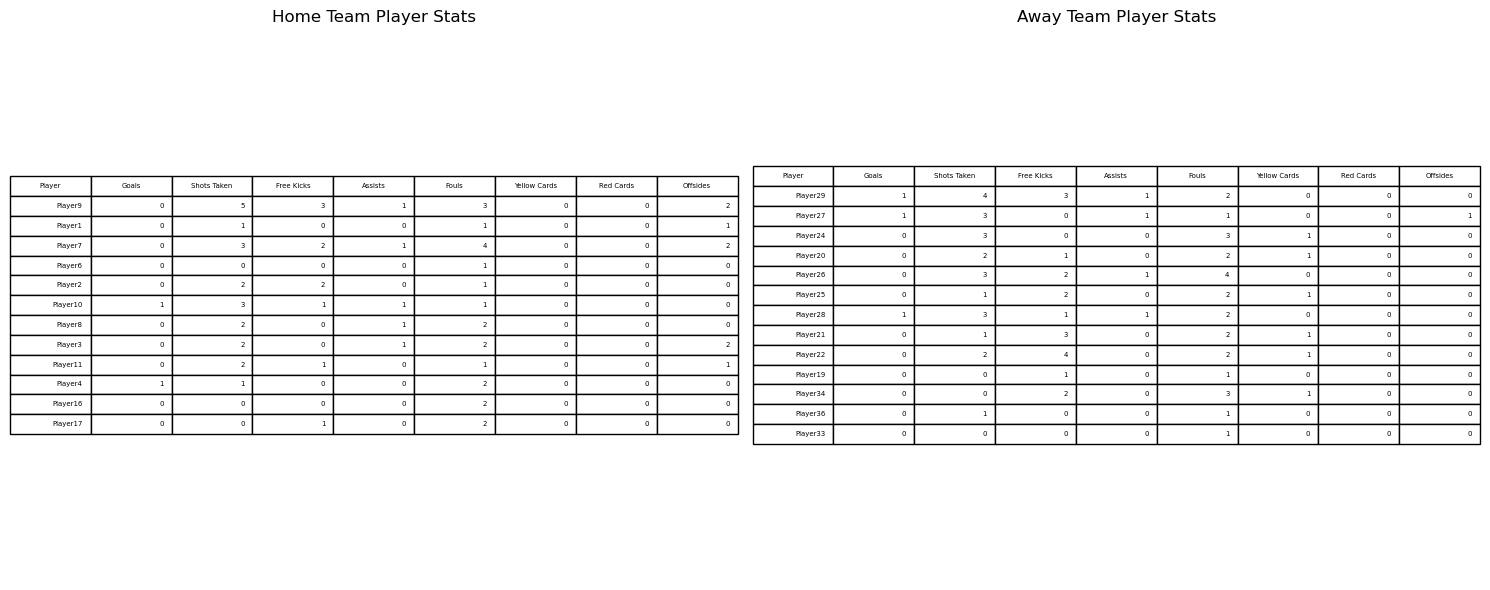

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot home team stats
axes[0].axis('tight')
axes[0].axis('off')
axes[0].table(cellText=home_df.values, colLabels=home_df.columns, loc='center')
axes[0].set_title('Home Team Player Stats')

# Plot away team stats
axes[1].axis('tight')
axes[1].axis('off')
axes[1].table(cellText=away_df.values, colLabels=away_df.columns, loc='center')
axes[1].set_title('Away Team Player Stats')

plt.tight_layout()
plt.show()

# Part 2: Fixing the LLM's Errors


## Part 2a. Totaling up Home/Away stats to see how far from correct we are

In [13]:
# Calculate column-wise sums for home and away dataframes
home_team_stats = home_df.iloc[:, 1:].sum()
away_team_stats = away_df.iloc[:, 1:].sum()

# Create a new dataframe for team-wise stats
team_stats = pd.DataFrame({
    'Team': ['Home Team', 'Away Team'],
    'Goals': [home_team_stats['Goals'], away_team_stats['Goals']],
    'Shots': [home_team_stats['Shots Taken'], away_team_stats['Shots Taken']],
    'Fouls': [home_team_stats['Fouls'], away_team_stats['Fouls']],
    'Yellow Cards': [home_team_stats['Yellow Cards'], away_team_stats['Yellow Cards']],
    'Red Cards': [home_team_stats['Red Cards'], away_team_stats['Red Cards']],
    'Free Kicks': [home_team_stats['Free Kicks'], away_team_stats['Free Kicks']],
    'Offsides': [home_team_stats['Offsides'], away_team_stats['Offsides']]
})
# Invert the rows to match the format of the ground truth table
team_stats = team_stats.iloc[::-1].reset_index(drop=True)
# Display the team-wise stats
display(team_stats)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides
0,Away Team,3,23,26,6,0,19,1
1,Home Team,2,21,22,0,0,10,8


In [14]:
# Drop the 'Corner Kicks' column from table_df
table_df = table_df.drop(columns=['Corner Kicks'])

# Display the updated DataFrame
display(table_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides
0,Away Team,2,12,18,4,0,12,1
1,Home Team,2,14,14,0,0,18,3


In [15]:
# Calculate the differences between `table_df` and `team_stats`
difference_df = table_df.set_index('Team').astype(int) - team_stats.set_index('Team')

# Reset the index for better readability
difference_df.reset_index(inplace=True)

# Display the resulting DataFrame
display(difference_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides
0,Away Team,-1,-11,-8,-2,0,-7,0
1,Home Team,0,-7,-8,0,0,8,-5
